In [17]:
import squidpy as sq
import scanpy as sc
import pandas as pd 
import numpy as np 
import sys
import os
sys.path.append(os.path.abspath(os.path.join(os.getcwd(), '../..')))
from adipo_finder import utils as seg_utils
from adipo_finder import segmentation as seg
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore")
import adipo_finder.new_adipofinder_code as nac
from skimage import measure, morphology, segmentation, feature
from scipy.ndimage import distance_transform_edt, label, binary_dilation
from sklearn.datasets import make_blobs
import torch


In [18]:
#get ground truth ids
import os
import glob
ground_truth_path = "../../../data/Manual_adipocyte_segmentation/"
old_pred_path = "../../../old_predictions/"
new_pred_path = "../../../new_predictions/"

# find all files ending with " step 1.tif"
files = glob.glob(os.path.join(ground_truth_path, "* step 3.tif"))

# extract IDs (everything before " step 1.tif")
gt_ids = [os.path.basename(f).replace(" step 3.tif", "") for f in files]

print(gt_ids)

['ROI001_02454_ROI_1', 'ROI001_026859_ROI_1', 'ROI001_08147_ROI_1', 'ROI001_31479_ROI_1', 'ROI001_40423_ROI_2', 'ROI001_44243_ROI_1', 'ROI001_50286_ROI_1', 'ROI001_62626_ROI_1', 'ROI001_70736_ROI_1', 'ROI001_J33533_ROI_1', 'ROI002_40900_ROI_1', 'ROI002_45504_ROI_1', 'ROI002_74014_ROI_1', 'ROI003_37912_ROI_1', 'ROI004_55218_ROI_1']


In [19]:
print(f"ground truth samples: {len(gt_ids)}")

ground truth samples: 15


In [20]:
from PIL import Image
pred_images_old = []
pred_images_new = []
ground_truth_images = []
for id in gt_ids:
    pred_images_old.append(np.array(Image.open(old_pred_path + id + " pred_adipocytes.png")))
    pred_images_new.append(np.array(Image.open(new_pred_path + id + " pred_adipocytes.png")))
    ground_truth_images.append(np.array(Image.open(ground_truth_path + id + " step 4.png")))
    

In [21]:
len(pred_images_new)

15

In [22]:
old_metrics = []
new_metrics = []
for i,gt_id in enumerate(gt_ids):
    old_metrics.append(nac.evaluate_segmentation(pred_images_old[i], ground_truth_images[i], overlap_threshold=0.4))
    new_metrics.append(nac.evaluate_segmentation(pred_images_new[i], ground_truth_images[i], overlap_threshold=0.4))



In [23]:
#tests

gt = np.array([
    [0,1,1,0],
    [0,1,1,0],
    [0,0,0,0],
    [0,0,0,0]
])

pred = np.array([
    [0,1,1,0],
    [0,1,1,0],
    [0,0,0,0],
    [0,0,0,0]
])

nac.evaluate_segmentation(pred, gt, overlap_threshold = 0.4) #looks ok, 1 TP

{'TP': [1],
 'FP': [],
 'FN': [],
 'TP_labels_in_GT': [1],
 'FP_best_GT': [],
 'FN_labels_in_GT': [],
 'tp_coverage': [1.0],
 'fp_coverage': [],
 'fn_coverage': []}

In [24]:
gt = np.array([
    [0,1,1,0],
    [0,1,1,0],
    [0,0,0,0],
    [0,0,0,0]
])

pred = np.array([
    [0,1,0,0],
    [0,1,0,0],
    [0,2,0,0],
    [0,2,0,0]
])

print(nac.evaluate_segmentation(pred, gt, overlap_threshold=0.6)) #looks ok, 2 FP, 1 FN
print(nac.evaluate_segmentation(pred, gt, overlap_threshold=0.4)) #looks ok, 1 TP, 1 FP, 0 FN, one false


{'TP': [], 'FP': [1, 2], 'FN': [None], 'TP_labels_in_GT': [], 'FP_best_GT': [1, None], 'FN_labels_in_GT': [1], 'tp_coverage': [], 'fp_coverage': [0.5, 0.0], 'fn_coverage': [0.0]}
{'TP': [1], 'FP': [2], 'FN': [], 'TP_labels_in_GT': [1], 'FP_best_GT': [None], 'FN_labels_in_GT': [], 'tp_coverage': [0.5], 'fp_coverage': [0.0], 'fn_coverage': []}


In [25]:
#we need the model to figure out which samples were training, validation, and test
model, train_ids, val_ids, test_ids = nac.load_model("../data/trained_model_main.pth")

In [26]:
len(train_ids)

9

In [27]:
len(val_ids)

3

In [28]:
len(test_ids)

3

In [29]:
eval_df = nac.get_pred_eval_dataframe(gt_ids, old_metrics, new_metrics, train_ids, val_ids, test_ids)
eval_df

,gt_id,split,P_old,R_old,F1_old,P_new,R_new,F1_new
0,ROI001_02454_ROI_1,test,0.710843,0.325967,0.446970,0.514970,0.945055,0.666667
1,ROI001_026859_ROI_1,train,0.627907,0.208494,0.313043,0.522976,0.922780,0.667598
2,ROI001_08147_ROI_1,train,0.623762,0.311881,0.415842,0.544643,0.901478,0.679035
3,ROI001_31479_ROI_1,val,0.727273,0.298507,0.423280,0.625698,0.835821,0.715655
4,ROI001_40423_ROI_2,train,0.764045,0.402367,0.527132,0.716495,0.822485,0.765840
5,ROI001_44243_ROI_1,train,0.703704,0.296875,0.417582,0.805785,0.761719,0.783133
6,ROI001_50286_ROI_1,train,0.507042,0.227848,0.314410,0.410920,0.905063,0.565217
7,ROI001_62626_ROI_1,train,0.727273,0.058824,0.108844,0.824818,0.830882,0.827839
8,ROI001_70736_ROI_1,train,0.843750,0.272727,0.412214,0.718841,0.835017,0.772586
9,ROI001_J33533_ROI_1,test,0.598039,0.383648,0.467433,0.505000,0.635220,0.562674


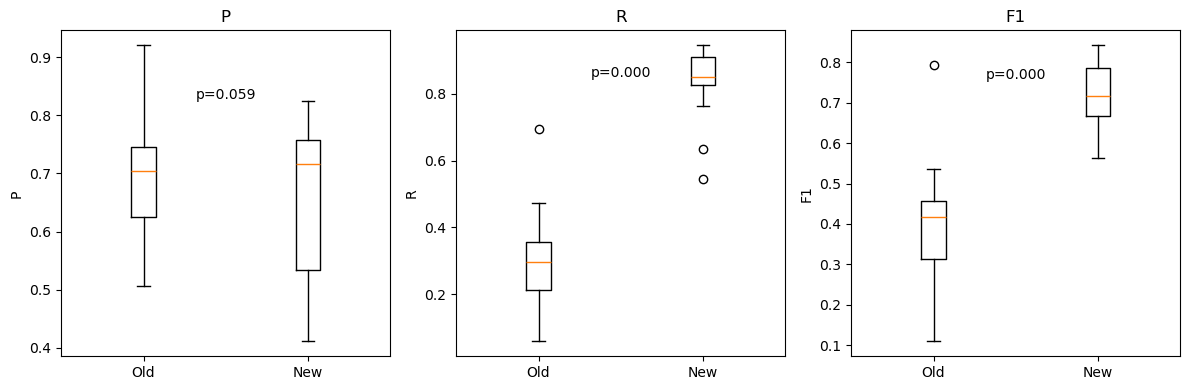

In [30]:
import matplotlib.pyplot as plt
from scipy.stats import ttest_rel

metrics = ["P", "R", "F1"]

plt.figure(figsize=(12, 4))

for i, m in enumerate(metrics):
    plt.subplot(1, 3, i+1)
    
    # Data for boxplot
    data_old = eval_df[f"{m}_old"]
    data_new = eval_df[f"{m}_new"]
    
    plt.boxplot([data_old, data_new], labels=["Old", "New"])
    plt.title(m)
    plt.ylabel(m)
    
    # Paired t-test
    t_stat, p_val = ttest_rel(data_old, data_new)
    plt.text(1.5, max(data_old.max(), data_new.max())*0.9, f"p={p_val:.3f}",
             ha='center', fontsize=10)
    
plt.tight_layout()
plt.show()


In [31]:
#export to file
eval_df.to_csv("../../../evaluation_old_vs_new.txt", sep='\t', index=False)

In [32]:
#this is just for reloading the new_adipofinder_code in case it has been modified,
#to aviod having to restart the notebook
import importlib
import adipo_finder.new_adipofinder_code as nac

importlib.reload(nac)

<module 'adipo_finder.new_adipofinder_code' from '/mnt/d/Code/Projects/adipocyte_finder/adipo_finder/adipo_finder/new_adipofinder_code.py'>